### Тестирование алгоритмов обнаружения разладки на искусственных данных

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import laplace
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
import math
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

%matplotlib inline

## Алгоритмы обнаружения разладки

### Метод, основанный на вычислении M-статистики

S. Li, Y. Xie, H. Dai, and L. Song, "M-statistic for kernel change-point detection” (NIPS, 2015)

In [2]:
# Функция для подсчета U-статистики согласно формулам (5.18)-(5.19)
# X -- 2D-массив наблюдений до предполагаемого момента разладки
# Y -- 2D-массив наблюдений после предполагаемого момента разладки
# sigma -- положительное число, настраиваемый параметр, отвечающий за форму ядра
#
# Возвращает число -- значение U-статистики согласно формулам (5.18)-(5.19)
def mmd_squared(X, Y, sigma):
    
    # Объем выборки
    n = X.shape[0]
    
    # Попарные расстояния
    xx_dist = pairwise_distances(X)
    xy_dist = pairwise_distances(X, Y)
    yy_dist = pairwise_distances(Y)
    
    # Значения ядра
    xx_kernel = np.exp(-0.5 * (xx_dist / sigma)**2) - np.identity(n)
    xy_kernel = np.exp(-0.5 * (xy_dist / sigma)**2) - np.identity(n)
    yy_kernel = np.exp(-0.5 * (yy_dist / sigma)**2) - np.identity(n)
    
    # Подсчет U-статистики
    u_stat = (np.sum(xx_kernel) - 2 * np.sum(xy_kernel) + np.sum(yy_kernel)) / n / (n - 1)
    
    return u_stat
    
# Вспомогательная функция для подсчета оценки дисперсии  
# Первое слагаемое в правой части формулы (5.20)
#
# X -- двумерный массив наблюдений
# sigma -- положительное число, настраиваемый параметр, отвечающий за форму ядра
#
# Возвращаемое значение -- число, первое слагаемое в правой части формулы (5.20) 
#
def h_squared(X, sigma):
    
    # Объем выборки
    n = X.shape[0]
    
    # Разбиваем наблюдения на 4 подвыборки
    n_max = 4 * (n // 4)
    X_1 = X[0:n_max:4]
    X_2 = X[1:n_max:4]
    X_3 = X[2:n_max:4]
    X_4 = X[3:n_max:4]
    
    K_12 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_2, axis=1) / sigma)**2)
    K_13 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_3, axis=1) / sigma)**2)
    K_24 = np.exp(-0.5 * (np.linalg.norm(X_2 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    return np.mean((K_12 - K_13 - K_24 + K_34)**2)


# Вспомогательная функция для подсчета оценки дисперсии    
# Второе слагаемое в правой части формулы (5.20)
#
# X -- двумерный массив наблюдений
# sigma -- положительное число, настраиваемый параметр, отвечающий за форму ядра
#
# Возвращаемое значение -- число, второе слагаемое в правой части формулы (5.20) 
#
def h_cov(X, sigma):
    
    # Объем выборки
    n = X.shape[0]
    
    # Разбиваем наблюдения на 6 подвыборок
    n_max = 6 * (n // 6)
    X_1 = X[0:n_max:6]
    X_2 = X[1:n_max:6]
    X_3 = X[2:n_max:6]
    X_4 = X[3:n_max:6]
    X_5 = X[4:n_max:6]
    X_6 = X[5:n_max:6]
    
    K_12 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_2, axis=1) / sigma)**2)
    K_13 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_3, axis=1) / sigma)**2)
    K_24 = np.exp(-0.5 * (np.linalg.norm(X_2 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    K_56 = np.exp(-0.5 * (np.linalg.norm(X_5 - X_6, axis=1) / sigma)**2)
    K_53 = np.exp(-0.5 * (np.linalg.norm(X_5 - X_3, axis=1) / sigma)**2)
    K_64 = np.exp(-0.5 * (np.linalg.norm(X_6 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    # Второе слагаемое в оценке дисперсии
    h_1234 = K_12 - K_13 - K_24 + K_34
    h_5634 = K_56 - K_53 - K_64 + K_34
    
    return np.mean((h_1234 - np.mean(h_1234)) * (h_5634 - np.mean(h_5634)))


# Оценка дисперсии согласно формуле (5.20)
#
# X -- двумерный массив наблюдений
# window_size -- натуральное число, ширина скользящего окна
# sigma -- положительное число, настраиваемый параметр, отвечающий за форму ядра
#
# Возвращаемое значение -- число, первое слагаемое в правой части формулы (5.20) 
#
def estimate_variance(X, window_size, sigma):
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
        
    # Объем выборки
    n = X.shape[0]
    
    # Первое слагаемое в оценке дисперсии
    h2 = h_squared(X, sigma) 
    
    # Второе слагаемое в оценке дисперсии
    h_c = h_cov(X, sigma)
    
    # Оценка дисперсии
    var = 2 * (h2 + h_c) / window_size / (window_size - 1)
        
    return np.maximum(var, 1e-5)


# Функция для вычисления тестовой статистики
#
# X -- двумерный массив наблюдений
# window_size -- натуральное число, ширина скользящего окна
# sigma -- положительное число, настраиваемый параметр, отвечающий за форму ядра
# threshold -- неотрицательное число, критическое значение тестовой статистики
#
# Возвращаемые значения:
# T -- одномерный массив значений тестовой статистики
# stopping_time -- натуральное число, момент превышения критического значения,
# то есть момент обнаружения разладки 
#
def compute_test_stat_mmd(X, window_size=10, sigma=0.1, threshold=math.inf):
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    
    b = window_size
    
    # Объем выборки
    n = X.shape[0]
    
    # Инициализация
    T = np.zeros(n)
    stopping_time = -1
    
    for t in range(2*b + 1, n):
        
        # Тестовая часть
        X_te = X[t-b:t, :]
        # Референсная часть
        X_re = X[t-2*b:t-b, :]
        
        # Вычисление меры расхождения по формулам (5.18)-(5.19)
        MMD_2 = mmd_squared(X_re, X_te, sigma)
        # Оценка дисперсии по формуле (5.20)
        var = estimate_variance(X_re, window_size, sigma)
        
        # Вычисление тестовой статистики по формуле (5.21)
        T[t] = MMD_2 / np.sqrt(var)
        
        # Если тестовая статистика превышает критическое значение,
        # остановить процедуру
        if T[t] > threshold:
        
            stopping_time = t
            break
    
    if stopping_time != -1:
        T = T[:stopping_time + 1]
    
    return T, stopping_time

### KLIEP, uLSIF, RuLSIF


KLIEP: M. Sugiyama, T. Suzuki, S. Nakajima, H. Kashima, P. von Bunau, and M. Kawanabe, "Direct importance estimation for covariate shift adaptation" (Ann. Inst. Appl. Math., 2008);

uLSIF: T. Kanamori, S. Hido, and M. Sugiyama, "A least-squares approach to direct importance estimation", (J. Mach. Learn. Res., 2009);

RuLSIF: M. Yamada, T. Suzuki, T. Kanamori, H. Hachiya, and M. Sugiyama, "Relative density-ratio estimation for robust distribution comparison" (Neural Computation, 2013)


Применение методов к задаче обнаружения разладки описано в работе 

S.Liu, M. Yamada, N. Collier, and M. Sugiyama, "Change-Point Detection in Time-Series Data by Relative Density-Ratio Estimation" (Neural Networks, 2013), ссылка: https://arxiv.org/pdf/1203.0453.pdf

In [3]:
# Вспомогательная функция для вычисления меры расхождения между
# тестовой частью наблюдений X_te и референсной X_re
#
# Параметр alpha используется только в алгоритме RuLSIF
#
# X_te, X_re -- массивы наблюдений до и после предполагаемого момента разладки
# sigma -- положительное число, параметр сглаживания, определяющий форму ядра
#
# alpha -- число из отрезка [0, 1], параметр меры расхождения в алгоритме RuLSIF
#
# Возвращаемое значение -- число, значение тестовой статистики
#
def divergence(X_te, X_re, sigma, method='kliep', alpha=0.5):
    
    # Длина тестового участка временного ряда
    n_te = X_te.shape[0]
    # Длина референсного участка временного ряда
    n_re = X_re.shape[0]
    
    # Попарные расстояния
    te_te_dist = pairwise_distances(X_te)
    re_te_dist = pairwise_distances(X_re, X_te)
    
    # Подсчет ядра
    te_te_kernel = np.exp(-0.5 * (te_te_dist / sigma)**2)
    re_te_kernel = np.exp(-0.5 * (re_te_dist / sigma)**2)
    
    # Выбираем один из трех методов: KLIEP, uLSIF, RuLSIF
    if method == 'kliep':
        
        # Составляем задачу оптимизации, как описано в Liu et al. (2013),
        # задача оптимизации на стр. 7
        
        # Начальное приближение для численного решения задачи оптимизации
        theta0 = 1 / np.mean(re_te_kernel) / n_te * np.ones(n_te)
        # Задаем ограничения
        constraints = []
        constraints += [LinearConstraint(np.ones((1, n_re)) @ re_te_kernel / n_re, 1, 1)]
        constraints += [LinearConstraint(np.eye(n_te), lb=0)] # theta >= 0
        # Функция, которую предстоит минимизировать
        #obj = lambda x : -1 * np.mean(np.log(np.maximum(te_te_kernel @ x, 1e-7)))
        obj = lambda x : -1 * np.mean(np.log(te_te_kernel @ x))
        # Градиент функции, которую предстоит минимизировать
        #grad = lambda x : -1 * np.diag(1 / np.maximum(te_te_kernel @ x, 1e-7))\
        #@ te_te_kernel.T @ np.ones(n_te) / n_te
        grad = lambda x : -1 * np.diag(1 / (te_te_kernel @ x)) @ te_te_kernel.T @ np.ones(n_te) / n_te
        
        # Численное решение сформулированной задачи оптимизации с помощью scipy
        res = minimize(obj, x0=theta0, constraints=constraints, tol=1e-4, jac=grad)
        # Выдать предупреждение, если метод оптимизации не сошелся
        if res.success != 1:
            print('Warning: the optimization method KLIEP did not converge')
        # Оптимальное значение параметра 
        theta = res.x
        
    elif method == 'ulsif':
        
        # Находим оптимальное значение параметра, явно решая
        # задачу оптимизации, описанную в Liu et al. (2013), формулы (6)-(7)
        theta = np.linalg.pinv(re_te_kernel.T @ re_te_kernel) @ te_te_kernel.T @ np.ones(te_te_kernel.shape[0])
        
    elif method == 'rulsif':
        # Находим оптимальное значение параметра, явно решая
        # задачу оптимизации, описанную в Liu et al. (2013), формула (6) и первая формула на стр. 11 
        theta = np.linalg.pinv(alpha * te_te_kernel.T @ te_te_kernel\
                               + (1 - alpha) * re_te_kernel.T @ re_te_kernel)\
        @ te_te_kernel.T @ np.ones(te_te_kernel.shape[0])
        
    # Вычисление оценки меры расхождения
    if method == 'kliep':
        # Liu et al. (2013), первая формула на стр. 8
        test_stat = np.mean(np.log(np.maximum(te_te_kernel @ theta, 1e-7)))
        
    elif method == 'ulsif':
        # Liu et al. (2013), первая формула главы 3.3.2
        test_stat = -0.5 * np.mean((re_te_kernel @ theta)**2) + np.mean(te_te_kernel @ theta) - 0.5
        
    elif method == 'rulsif':
        # Liu et al. (2013), первая формула главы 3.4.3
        test_stat = -0.5 * alpha * np.mean((te_te_kernel @ theta)**2)\
        - 0.5 * (1 - alpha) * np.mean((re_te_kernel @ theta)**2) + np.mean(te_te_kernel @ theta) - 0.5
    
    return test_stat

# Функция для вычисления тестовой статистики
#
# X -- массив наблюдений
#
# window_size -- натуральное число, ширина скользящего окна
#
# sigma -- положительное число, параметр сглаживания, bandwidth
#
# threshold -- неотрицательное число, критическое значение тестовой статистики
#
# method -- один из трех методов: kliep, ulsif, rulsif
#
# alpha -- число из отрезка [0, 1], параметр, использующийся только в rulsif; определяет меру расхождения
#
# Возвращаемые значения:
# T -- одномерный массив значений тестовой статистики
# stopping_time -- натуральное число, момент превышения критического значения,
# то есть момент обнаружения разладки 
#
def compute_divergence_test_stat(X, window_size=10, sigma=0.1, threshold=math.inf, method='kliep', alpha=0.5):
    
    if (method not in ['kliep', 'ulsif', 'rulsif']):
        raise ValueError()
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    
    b = window_size
    
    # Объем выборки
    n = X.shape[0]
    
    # Инициализация
    T = np.zeros(n)
    stopping_time = -1
    
    for t in range(2*b + 1, n):
        
        # Тестовая часть
        X_te = X[t-b:t]
        # Референсная часть
        X_re = X[t-2*b:t-b]
        
        # Вычисление тестовой статистики по формуле (5.12)
        T[t] = 0.5 * (divergence(X_te, X_re, sigma, method=method, alpha=alpha)\
                      + divergence(X_re, X_te, sigma, method=method, alpha=alpha))
        
        # Если тестовая статистика превышает критическое значение,
        # остановить процедуру
        if T[t] > threshold:
        
            stopping_time = t
            break
    
    if stopping_time != -1:
        T = T[:stopping_time + 1]
    
    return T, stopping_time

### CUSUM

**Описание в отчете:** секция 5.1, алгоритм 4

In [4]:
# Функция для вычисления тестовой статистики
#
# X -- массив наблюдений
#
# Возвращаемые значения:
# T -- одномерный массив значений тестовой статистики
#
def compute_cusum(X):
    
    T = np.zeros(X.shape[0])
    
    for n in range(1, X.shape[0]):
        
        t = np.zeros(n)
        
        # Шаг 2 алгоритма 4: вычисление выражения (5.5)
        for k in range(1, n):
            t[k] = abs((n - k) * X[:k].sum()   - k * X[k:n].sum() ) / np.sqrt(n * k * (n - k))
        
        # Шаг 3 алгоритма 4: вычисление тестовой статистики (5.6)
        T[n] = np.max(t)
    
    return T

### Контрастный метод

N. Puchkin and V. Shcherbakova, "A Contrastive Approach to Online Change Point Detection" (AISTATS, 2023)

**Описание в отчете:** секция 5.5, алгоритм 6

In [5]:
#------------------------------------------------------------------------------
# Версия алгоритма с линейным референсным классом функций
#------------------------------------------------------------------------------


# Вспомогательные функции для вычисления матриц дизайна

# Полиномиальный дизайн
#
# X -- массив одномерных наблюдений
#
# p -- натуральное число, степень полинома
#
# Возвращаемое значение -- матрица дизайна размера n x p
#
def compute_design_poly(X, p):
    
    n = X.shape[0]
    Psi = np.power(np.outer(X, np.ones(p)), np.outer(np.ones(n), np.arange(p)))
    
    return Psi
    
# Дизайн на основе системы функций 1, cos(2 * pi * x), sin(2 * pi * x), ... 
#
# X -- массив одномерных наблюдений
#
# p -- натуральное число, число элементов ортогональной системы функций
#
# Возвращаемое значение -- матрица дизайна размера n x p
#    
def compute_design_Fourier(X, p):
    res = np.zeros((p, X.shape[0]))
    res[0] = np.ones(X.shape[0]) / np.sqrt(2)
    T = 1
    for i in range(1, p):
        if (i // 2 == 0):
            res[i] = np.sin(X * 2 * np.pi * i / T) / np.sqrt(T / 2)
        else:
            res[i] = np.cos(X * (2 * np.pi * i) / T) / np.sqrt(T / 2)
    return res.T

# Аффинный дизайн 
#
# X -- массив наблюдений (возможно, многомерных)
#
# Возвращаемое значение -- матрица дизайна
#    
def compute_design_multivariate(X):
    
    Psi = np.append(np.ones((X.shape[0], 1)), X, axis=1)
    
    return Psi
    
    
# Вспомогательная функция для оценки значения параметра
#
# Psi -- матрица дизайна
#
# tau -- натуральное число, предполагаемый момент разладки
#
# Возвращаемое значение -- вектор, значение параметра, максимизирующее меру расхождения
#
def compute_theta(Psi, tau):
    
    # Sample size
    t = Psi.shape[0]
    
    # Помечаем точки до разладки как класс +1, точки после разладки - как класс -1
    Y = np.append(np.ones(tau), -np.ones(t - tau))
    
    # Шаг 2 алгоритма 6: оптимизация выражения (5.25). Выражение (5.25) - перевзвешенная функция потерь логистической регрессии
    # Следующая часть программы - решение сформулированной оптимизационной задачи
    
    lr = LogisticRegression(penalty='none', fit_intercept=False, tol=1e-2,\
                            solver='lbfgs', class_weight='balanced', n_jobs=-1)
    lr.fit(Psi, Y)
    
    
    
    theta = (lr.coef_).reshape(-1)
    
    return theta
    
    
# Вычисление тестовой статистики
#
# X -- массив наблюдений
#
# p -- натуральное число, количество базисных функций (применяется, если design="poly" или design="fourier")
#
# t_min -- натуральное число, минимальное количество наблюдений, необходимое для расчета тестовой статистики
#
# n_out_min, delta_max -- натуральные числа;
# Предполагаемый момент разладки tau в момент времени t
# пробегает значения от max{n_out_min, t - n_out_min - delta_max} до t-n_out_min;
# n_out_min позволяет избежать ситуаций, когда до или после предполагаемого момента разладки мало наблюдений
# delta_max позволяет не рассматривать бывшие давно моменты времени в качестве кандидатов на точку разладки,
# экономя время для вычислений
# 
# B -- положительное число, уровень срезки значений функции
# (чтобы избежать проблем с вычислением тестовой статистики)
#
# design -- способ вычисления матрицы дизайна
#
# threshold -- критическое значение тестовой статистики
#
# Возвращаемые значения:
# S -- одномерный массив значений тестовой статистики
# stopping_time -- натуральное число, момент превышения критического значения,
# то есть момент обнаружения разладки 
#
def compute_test_stat_linear(X, p, t_min=20, n_out_min=10, B=10, delta_max=150, design="poly", threshold=math.inf):
    
    # Объем выборки
    n = X.shape[0]
    
    # Шаг 1 алгоритма 6: получаем наблюдения X. 
    # В зависимости от функции f для удобства сразу переходим к работе с f(X)
    # Вычисление матрицы дизайна
    if design == "poly":
        Psi = compute_design_poly(X, p)
    elif design == "fourier":
        Psi = compute_design_Fourier(X, p)
    elif design == "multivariate":
        Psi = compute_design_multivariate(X)
        p = X.shape[1] + 1
    else:
        raise ValueError()
    
    # Инициализация
    T = np.zeros((n, n))
    S = np.zeros(n)
    
    stopping_time = -1

    for t in range(t_min, n):
        
        D = np.zeros(t)
        
        # Шаг 2 алгоритма 6: оптимизация выражения (5.25) для каждого tau
        
        for tau in range(np.maximum(n_out_min, t - n_out_min - delta_max), t-n_out_min):
            
            # Вычисление оценки параметра theta
            theta = compute_theta(Psi[:t, :], tau)
            Z = Psi[:t, :] @ theta
            
            # Для избежания проблем с возведением в степень
            Z = np.minimum(Z, B)
            Z = np.maximum(Z, -B)
            
            D[:tau] = 2 / (1 + np.exp(-Z[:tau]))
            D[tau:] = 2 / (1 + np.exp(Z[tau:]))
            D = np.log(D)
            
            T[tau, t] = tau * (t - tau) / t * (np.mean(D[:tau]) + np.mean(D[tau:]))
           
        # Шаг 3 алгоритма 6: вычисление тестовой статистики (5.26)
        # Шаг 4 алгоритма 6: Если тестовая статистика превышает критическое значение, остановить процедуру
        S[t] = np.max(T[:, t])
        if S[t] > threshold:
        
            stopping_time = t
            break
            
    if stopping_time != -1:
        S = S[:stopping_time + 1]
    
    return S, stopping_time

### Онлайн выпуклая оптимизация

Y. Cao, L. Xie, Y. Xie, H. Xu, " change-point detection via online convex optimization" (Entropy, 2018)

**Описание в отчете:** секция 5.2, алгоритм 5

In [6]:
# Функция для вычисления тестовой статистики
#
# X -- массив наблюдений
#
# t_min -- число шагов, после которого производится
# оценка начального значения параметра
#
# Возвращаемые значения -- одномерный массив значений тестовой статистики
#
def compute_test_stat_oco(X, t_min=20):
    
    # Оценить значение параметра на стационарном участке
    X_stationary = X[:t_min]
    theta_0 = np.mean(X_stationary, axis=0)
    
    # Инициализация
    lambda_array = []
    
    for k in range(t_min, X.shape[0]):
        
        # Логарифм тестовой статистики, вычисляемой в Алгоритме 5 (см. отчет)
        log_lambda_k_t = k * [0]
        theta = theta_0
        
        for t in range(k, X.shape[0]):
            
            # Рекурсивное вычисление тестовой статистики
            log_ratio = log_lambda_k_t[-1] + X[t] @ (theta - theta_0)\
            + 0.5 * np.linalg.norm(theta_0)**2 - 0.5 * np.linalg.norm(theta)**2
        
            log_lambda_k_t += [log_ratio]
        
            # Обновление параметра theta
            theta = theta * (1 - 1 / (t + 1)) + 1 / (t + 1) * X[t]
        
        # Массив значений log_lambda_k_t для всех k и t
        lambda_array += [log_lambda_k_t]
        
    # Тестовая статистика, вычисляемая по формуле (5.9)
    test_stat = np.max(np.array(lambda_array), axis=0)
        
    return test_stat

## Эксперименты на искусственных данных (результаты представлены в отчете в секции 5.6.1)

### Сдвиг среднего в нормальной модели

#### Контрастный метод

In [7]:
# Вычисление критических значений

# Число наблюдений
n = 150

# Стандартное отклонение
sigma = 0.1

np.random.seed(1)

p = 2
S_poly_list = []

# Сгенерировать гауссовскую последовательность
# и вычислить соответствующие значения тестовых
# статистик 9 раз
for item in tqdm(range(9)):
    
    X = sigma * randn(n)

    S_poly, _ = compute_test_stat_linear(X, p)
    
    S_poly_list.append(S_poly)

S_poly_np = np.array(S_poly_list)

threshold_p_2_poly = np.max(S_poly_np)

100%|█████████████████████████████████████████████| 9/9 [01:16<00:00,  8.47s/it]


In [8]:
np.random.seed(1)

# Число наблюдений
n = 150
# Момент разладки
tau = 75

# Сдвиг
mu = 0.2

# Стандартное отклонение
sigma = 0.1

p = 2
S_poly_list = []

for item in tqdm(range(10)):
    
    # Сгенерировать гауссовскую последовательность
    X = sigma * randn(n)
    X[tau:] += mu

    # Запустить контрастный метод обнаружения разладки
    S_poly, _ = compute_test_stat_linear(X, p)
    
    S_poly_list.append(S_poly)

100%|███████████████████████████████████████████| 10/10 [01:27<00:00,  8.76s/it]


In [9]:
# Вычисление задержки в обнаружении момента разладки 

t_lin = []

fa_lin = 0

for i in range(10):

    S_lin = S_poly_list[i]
    imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_2_poly))
    
    if imin_lin - tau <= 0:
        fa_lin += 1
    else:
        t_lin.append(imin_lin - tau)
            
print('Число ложных срабатываний. Контрастный метод:', fa_lin)

Число ложных срабатываний. Контрастный метод: 0


In [10]:
# Вывод среднего времени задержки обнаружения

t_lin_np = np.array(t_lin)
DD_poly = np.round(t_lin_np.mean(), 1)
std_DD_poly = np.round(t_lin_np.std(), 1)
print('Задержка обнаружения, контрастный метод:', DD_poly, '±', std_DD_poly)

Задержка обнаружения, контрастный метод: 6.7 ± 2.0


#### Онлайн выпуклая оптимизация

In [11]:
# Вычисление критических значений

# Число наблюдений
n = 150

# Стандартное отклонение
sigma = 0.1

np.random.seed(1)

S_oco_list = []

# Сгенерировать гауссовскую последовательность
# и вычислить соответствующие значения тестовых
# статистик 9 раз
for item in tqdm(range(9)):
    
    X = sigma * randn(n)

    S_oco = compute_test_stat_oco(X.reshape(-1, 1))
    
    S_oco_list.append(S_oco)
    
S_oco_np = np.array(S_oco_list)

threshold_oco = np.max(S_oco_np)
print(threshold_oco)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 19.48it/s]

0.03881463413021199


In [12]:
np.random.seed(1)

# Число наблюдений
n = 150
# Момент разладки
tau = 75

# Сдвиг
mu = 0.2

# Стандартное отклонение
sigma = 0.1

S_oco_list = []

for item in tqdm(range(10)):
    
    # Сгенерировать гауссовскую последовательность
    X = sigma * randn(n)
    X[tau:] += mu

    # Запустить метод обнаружения разладки, основанный на выпуклой оптимизации
    S_oco = compute_test_stat_oco(X.reshape(-1, 1))
    
    S_oco_list.append(S_oco)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.24it/s]


In [13]:
# Вычисление задержки в обнаружении момента разладки 
t_oco = []

fa_oco = 0

for i in range(10):

    S_oco = S_oco_list[i]
    imin_oco = np.min(np.ma.flatnotmasked_edges(np.ma.masked_array(S_oco, S_oco <= threshold_oco)))
    
    if imin_oco - tau <= 0:
        fa_oco += 1
    else:
        t_oco.append(imin_oco - tau)
        
print('Число ложных срабатываний, онлайн выпуклая оптимизация:', fa_oco)

Число ложных срабатываний, онлайн выпуклая оптимизация: 0


In [14]:
# Вывод среднего времени задержки обнаружения

t_oco_np = np.array(t_oco)
DD_oco = np.round(t_oco_np.mean(), 1)
std_DD_oco = np.round(t_oco_np.std(), 1)
print('Задержка обнаружения, онлайн выпуклая оптимизация:', DD_oco, '±', std_DD_oco)

Задержка обнаружения, онлайн выпуклая оптимизация: 9.7 ± 3.7


#### Остальные методы

In [15]:
# Вычисление критических значений

# Число наблюдений
n = 150

# Стандартное отклонение
sigma = 0.1

# Сгенерировать гауссовскую последовательность
# и вычислить соответствующие значения тестовых
# статистик 9 раз
np.random.seed(1)
S_kliep_list = []
S_ulsif_list = []
S_rulsif_list = []
S_mmd_list = []
S_cusum_list = []

for item in tqdm(range(9)):
    
    X = sigma * randn(n)

    S_kliep, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='kliep')
    S_ulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='ulsif')
    S_rulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='rulsif')
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.5)
    S_cusum = compute_cusum(X)
    
    S_kliep_list.append(S_kliep)
    S_ulsif_list.append(S_ulsif)
    S_rulsif_list.append(S_rulsif)
    S_mmd_list.append(S_mmd)
    S_cusum_list.append(S_cusum)
    
S_kliep_np = np.array(S_kliep_list)
S_ulsif_np = np.array(S_ulsif_list)
S_rulsif_np = np.array(S_rulsif_list)
S_mmd_np = np.array(S_mmd_list)
S_cusum_np = np.array(S_cusum_list)

threshold_kliep = np.round(np.max(S_kliep_np), 4)
threshold_ulsif = np.round(np.max(S_ulsif_np), 4)
threshold_rulsif = np.round(np.max(S_rulsif_np), 4)
threshold_mmd = np.round(np.max(S_mmd_np), 4)
threshold_cusum = np.round(np.max(S_cusum_np), 4)

print(threshold_kliep)
print(threshold_ulsif)
print(threshold_rulsif)
print(threshold_mmd)
print(threshold_cusum)

100%|█████████████████████████████████████████████| 9/9 [00:02<00:00,  3.86it/s]

0.2398
26977.7366
0.2905
9.5924
0.4469


In [16]:
# Запуск на тестовой выборке
np.random.seed(1)

# Число наблюдений
n = 150
# Момент разладки
tau = 75

# Сдвиг
mu = 0.2

# Стандартное отклонение
sigma = 0.1

S_kliep_list = []
S_ulsif_list = []
S_rulsif_list = []
S_mmd_list = []
S_cusum_list = []

for item in tqdm(range(10)):
    
    # Сгенерировать гауссовскую последовательность
    X = sigma * randn(n)
    X[tau:] += mu

    S_kliep, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='kliep')
    S_ulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='ulsif')
    S_rulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='rulsif')
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.5)
    S_cusum = compute_cusum(X)
    
    S_kliep_list.append(S_kliep)
    S_ulsif_list.append(S_ulsif)
    S_rulsif_list.append(S_rulsif)
    S_mmd_list.append(S_mmd)
    S_cusum_list.append(S_cusum)

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.75it/s]


In [17]:
# Вычисление задержки в обнаружении момента разладки 

t_kliep = []
t_ulsif = []
t_rulsif = []
t_mmd = []
t_cusum = []

fa_kliep = 0
fa_ulsif = 0
fa_rulsif = 0
fa_mmd = 0
fa_cusum = 0

for i in range(10):

    S_kliep = S_kliep_list[i]
    S_ulsif = S_ulsif_list[i]
    S_rulsif = S_rulsif_list[i]
    S_mmd = S_mmd_list[i]
    S_cusum = S_cusum_list[i]
    
    if np.sum(S_kliep > threshold_kliep) > 0:
        imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep))
    else:
        imin_kliep = n
    
    if np.sum(S_ulsif > threshold_ulsif) > 0:
        imin_ulsif, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_ulsif, S_ulsif <= threshold_ulsif))
    else:
        imin_ulsif = n
    
    if np.sum(S_rulsif > threshold_rulsif) > 0:
        imin_rulsif, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_rulsif, S_rulsif <= threshold_rulsif))
    else:
        imin_rulsif = n
    
    if np.sum(S_mmd > threshold_mmd) > 0:
        imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd))
    else:
        imin_mmd = n
        
    if np.sum(S_cusum > threshold_cusum) > 0:
        imin_cusum, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_cusum, S_cusum <= threshold_cusum))
    else:
        imin_cusum = n
    
    
    if imin_kliep - tau <= 0:
        fa_kliep += 1
    else:
        t_kliep.append(imin_kliep - tau)
        
    if imin_ulsif - tau <= 0:
        fa_ulsif += 1
    else:
        t_ulsif.append(imin_ulsif - tau)
    
    if imin_rulsif - tau <= 0:
        fa_rulsif += 1
    else:
        t_rulsif.append(imin_rulsif - tau)
        
    if imin_mmd - tau <= 0:
        fa_mmd += 1
    else:
        t_mmd.append(imin_mmd - tau)
        
    if imin_cusum - tau <= 0:
        fa_cusum += 1
    else:
        t_cusum.append(imin_cusum - tau)
        
print('KLIEP. Число ложных срабатываний:', fa_kliep)
print('uLSIF. Число ложных срабатываний:', fa_ulsif)
print('RuLSIF. Число ложных срабатываний:', fa_rulsif)
print('M-статистика. Число ложных срабатываний:', fa_mmd)
print('CUSUM. Число ложных срабатываний:', fa_cusum)

KLIEP. Число ложных срабатываний: 0
uLSIF. Число ложных срабатываний: 0
RuLSIF. Число ложных срабатываний: 0
M-статистика. Число ложных срабатываний: 0
CUSUM. Число ложных срабатываний: 0


In [18]:
# Вывод среднего времени задержки обнаружения

t_kliep_np = np.array(t_kliep)
DD_kliep = np.round(t_kliep_np.mean(), 1)
std_DD_kliep = np.round(t_kliep_np.std(), 1)
print('Задержка обнаружения. KLIEP:', DD_kliep, '±', std_DD_kliep)

t_ulsif_np = np.array(t_ulsif)
DD_ulsif = np.round(t_ulsif_np.mean(), 1)
std_DD_ulsif = np.round(t_ulsif_np.std(), 1)
print('Задержка обнаружения, uLSIF:', DD_ulsif, '±', std_DD_ulsif)

t_rulsif_np = np.array(t_rulsif)
DD_rulsif = np.round(t_rulsif_np.mean(), 1)
std_DD_rulsif = np.round(t_rulsif_np.std(), 1)
print('Задержка обнаружения. RuLSIF:', DD_rulsif, '±', std_DD_rulsif)

t_mmd_np = np.array(t_mmd)
DD_mmd = np.round(t_mmd_np.mean(), 1)
std_DD_mmd = np.round(t_mmd_np.std(), 1)
print('Задержка обнаружения. M-статистика:', DD_mmd, '±', std_DD_mmd)

t_cusum_np = np.array(t_cusum)
DD_cusum = np.round(t_cusum_np.mean(), 1)
std_DD_cusum = np.round(t_cusum_np.std(), 1)
print('Задержка обнаружения. CUSUM:', DD_cusum, '±', std_DD_cusum)

Задержка обнаружения. KLIEP: 9.2 ± 2.8
Задержка обнаружения, uLSIF: 9.9 ± 6.1
Задержка обнаружения. RuLSIF: 28.8 ± 23.2
Задержка обнаружения. M-статистика: 10.4 ± 3.4
Задержка обнаружения. CUSUM: 5.0 ± 2.0


### Изменение дисперсии в нормальной модели

#### Контрастный метод

In [19]:
# Вычисление критического значения для полиномов

# Число наблюдений
n = 150

# Стандартное отклонение
sigma = 0.1

np.random.seed(1)

p = 3
S_poly_list = []

# Сгенерировать гауссовскую последовательность
# и вычислить соответствующие значения тестовых
# статистик 9 раз
for item in tqdm(range(9)):
    
    X = sigma * randn(n)

    S_poly, _ = compute_test_stat_linear(X, p)
    
    S_poly_list.append(S_poly)
    
S_poly_np = np.array(S_poly_list)

threshold_p_3_poly = np.max(S_poly_np)

100%|█████████████████████████████████████████████| 9/9 [01:27<00:00,  9.71s/it]


In [20]:
np.random.seed(1)

# Число наблюдений
n = 150
# Момент разладки
tau = 75

# Стандартное отклонение до разладки
sigma_1 = 0.1
# Стандартное отклонение после разладки
sigma_2 = 0.3

p = 3
S_poly_list = []

for item in tqdm(range(10)):
    
    # Сгенерировать гауссовскую последовательность наблюдений
    X = randn(n)
    X[:tau] *= sigma_1
    X[tau:] *= sigma_2

    S_poly, _ = compute_test_stat_linear(X, p)
    
    S_poly_list.append(S_poly)

100%|███████████████████████████████████████████| 10/10 [01:39<00:00,  9.92s/it]


In [21]:
# Вычисление задержки в обнаружении момента разладки 

t_lin = []

fa_lin = 0

for i in range(10):

    S_lin = S_poly_list[i]
    imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_3_poly))
    
    if imin_lin - tau <= 0:
        fa_lin += 1
    else:
        t_lin.append(imin_lin - tau)
            
print('Число ложных срабатываний. Контрастный метод:', fa_lin)

Число ложных срабатываний. Контрастный метод: 0


In [22]:
# Вывод средней задержки обнаружения

t_lin_np = np.array(t_lin)
DD_poly = np.round(t_lin_np.mean(), 1)
std_DD_poly = np.round(t_lin_np.std(), 1)
print('Задержка обнаружения, полиномы:', DD_poly, '±', std_DD_poly)

Задержка обнаружения, полиномы: 16.4 ± 8.1


#### Остальные методы

In [23]:
# Вычисление критических значений

# Число наблюдений
n = 150

# Стандартное отклонение
sigma = 0.1

# Сгенерировать гауссовскую последовательность
# и вычислить соответствующие значения тестовых
# статистик 9 раз
np.random.seed(1)
S_kliep_list = []
S_ulsif_list = []
S_rulsif_list = []
S_mmd_list = []

for item in tqdm(range(9)):
    
    X = sigma * randn(n)

    S_kliep, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.33, method='kliep')
    S_ulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=33, method='ulsif')
    S_rulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=33, method='rulsif')
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.1)
    
    S_kliep_list.append(S_kliep)
    S_ulsif_list.append(S_ulsif)
    S_rulsif_list.append(S_rulsif)
    S_mmd_list.append(S_mmd)
    
S_kliep_np = np.array(S_kliep_list)
S_ulsif_np = np.array(S_ulsif_list)
S_rulsif_np = np.array(S_rulsif_list)
S_mmd_np = np.array(S_mmd_list)

threshold_kliep = np.round(np.max(S_kliep_np), 4)
threshold_ulsif = np.round(np.max(S_ulsif_np), 4)
threshold_rulsif = np.round(np.max(S_rulsif_np), 4)
threshold_mmd = np.round(np.max(S_mmd_np), 4)

print(threshold_kliep)
print(threshold_ulsif)
print(threshold_rulsif)
print(threshold_mmd)

100%|█████████████████████████████████████████████| 9/9 [00:02<00:00,  4.49it/s]

0.105
0.631
0.1189
36.745


In [24]:
# Запуск на тестовой выборке 
np.random.seed(1)

# Число наблюдений
n = 150
# Момент разладки
tau = 75

# Стандартное отклонение до разладки
sigma_1 = 0.1
# Стандартное отклонение после разладки
sigma_2 = 0.3

S_kliep_list = []
S_mmd_list = []

for item in tqdm(range(10)):
    
    # Сгенерировать гауссовскую последовательность
    X = randn(n)
    X[:tau] *= sigma_1
    X[tau:] *= sigma_2
    
    S_kliep, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.33, method='kliep')
    S_ulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.33, method='ulsif')
    S_rulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.33, method='rulsif')
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.1)
    
    S_kliep_list.append(S_kliep)
    S_ulsif_list.append(S_ulsif)
    S_rulsif_list.append(S_rulsif)
    S_mmd_list.append(S_mmd)

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.20it/s]


In [25]:
# Вычисление задержки в обнаружении момента разладки 
t_kliep = []
t_ulsif = []
t_rulsif = []
t_mmd = []
t_cusum = []

fa_kliep = 0
fa_ulsif = 0
fa_rulsif = 0
fa_mmd = 0
fa_cusum = 0

for i in range(10):

    S_kliep = S_kliep_list[i]
    S_ulsif = S_ulsif_list[i]
    S_rulsif = S_rulsif_list[i]
    S_mmd = S_mmd_list[i]
    S_cusum = S_cusum_list[i]
    
    if np.sum(S_kliep > threshold_kliep) > 0:
        imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep))
    else:
        imin_kliep = n
    
    if np.sum(S_ulsif > threshold_ulsif) > 0:
        imin_ulsif, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_ulsif, S_ulsif <= threshold_ulsif))
    else:
        imin_ulsif = n
    
    if np.sum(S_rulsif > threshold_rulsif) > 0:
        imin_rulsif, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_rulsif, S_rulsif <= threshold_rulsif))
    else:
        imin_rulsif = n
    
    if np.sum(S_mmd > threshold_mmd) > 0:
        imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd))
    else:
        imin_mmd = n
        
    if imin_kliep - tau <= 0:
        fa_kliep += 1
    else:
        t_kliep.append(imin_kliep - tau)
        
    if imin_ulsif - tau <= 0:
        fa_ulsif += 1
    else:
        t_ulsif.append(imin_ulsif - tau)
    
    if imin_rulsif - tau <= 0:
        fa_rulsif += 1
    else:
        t_rulsif.append(imin_rulsif - tau)
        
    if imin_mmd - tau <= 0:
        fa_mmd += 1
    else:
        t_mmd.append(imin_mmd - tau)
            
print('KLIEP. Число ложных срабатываний:', fa_kliep)
print('uLSIF. Число ложных срабатываний:', fa_ulsif)
print('RuLSIF. Число ложных срабатываний:', fa_rulsif)
print('M-статистика. Число ложных срабатываний:', fa_mmd)

KLIEP. Число ложных срабатываний: 0
uLSIF. Число ложных срабатываний: 1
RuLSIF. Число ложных срабатываний: 0
M-статистика. Число ложных срабатываний: 0


In [26]:
# Вывод средней задержки обнаружения
t_kliep_np = np.array(t_kliep)
DD_kliep = np.round(t_kliep_np.mean(), 1)
std_DD_kliep = np.round(t_kliep_np.std(), 1)
print('Задержка обнаружения. KLIEP:', DD_kliep, '±', std_DD_kliep)

t_ulsif_np = np.array(t_ulsif)
DD_ulsif = np.round(t_ulsif_np.mean(), 1)
std_DD_ulsif = np.round(t_ulsif_np.std(), 1)
print('Задержка обнаружения, uLSIF:', DD_ulsif, '±', std_DD_ulsif)

t_rulsif_np = np.array(t_rulsif)
DD_rulsif = np.round(t_rulsif_np.mean(), 1)
std_DD_rulsif = np.round(t_rulsif_np.std(), 1)
print('Задержка обнаружения. RuLSIF:', DD_rulsif, '±', std_DD_rulsif)

t_mmd_np = np.array(t_mmd)
DD_mmd = np.round(t_mmd_np.mean(), 1)
std_DD_mmd = np.round(t_mmd_np.std(), 1)
print('Задержка обнаружения. M-статистика:', DD_mmd, '±', std_DD_mmd)

Задержка обнаружения. KLIEP: 17.8 ± 12.5
Задержка обнаружения, uLSIF: 75.0 ± 0.0
Задержка обнаружения. RuLSIF: 63.1 ± 24.3
Задержка обнаружения. M-статистика: 51.1 ± 27.3


## Эксперименты на наборе данных WISDM (результаты представлены в отчете в секции 5.6.2)

In [27]:
# Вспомогательная функция для вычисления задержек обнаружения
def compute_delays(true_cp, detected_cp):
    
    false_alarms = 0
    not_detected = 0
    delays = []
    
    cp_all = np.append(true_cp, detected_cp)
    pattern = np.append(np.zeros(len(true_cp)), np.ones(len(detected_cp)))
    
    ind_sorted = np.argsort(cp_all)
    cp_sorted = cp_all[ind_sorted]
    pattern_sorted = pattern[ind_sorted]
    
    if pattern_sorted[0] == 1:
        false_alarms += 1
        
    for i in range(1, len(pattern_sorted)):

        # Правильно обнаруженная разладка
        if (pattern_sorted[i] == 1) and (pattern_sorted[i - 1] == 0):
            delays += [cp_sorted[i] - cp_sorted[i - 1]]
            
        # Ложное срабатывание
        if (pattern_sorted[i] == 1) and (pattern_sorted[i - 1] == 1) and (i < len(pattern_sorted) - 1):
            false_alarms += 1
            
        # Пропущенная разладка
        if (pattern_sorted[i] == 0) and (pattern_sorted[i - 1] == 0):
            delays += [cp_sorted[i] - cp_sorted[i - 1]]
            not_detected += 1
            
    delays = np.array(delays)
    delays_mean = np.mean(delays)
    delays_std = np.std(delays)
    
    return false_alarms, delays_mean, delays_std, not_detected

In [28]:
# Чтение данных
df = pd.read_csv('data/WISDM/sample_0.csv')

X = np.array(df[['X1', 'X2', 'X3']])
print(X.shape)

labels = np.array(df['Label'])
change_points = np.where(labels)[0]

(64868, 3)


In [29]:
# Обработка данных

bandwidth = 20
N = X.shape[0] // bandwidth

data = np.empty((0, 3))
new_labels = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(X[bandwidth * t : bandwidth * (t + 1)], axis=0).reshape(1, -1), axis=0)
    new_labels = np.append(new_labels, np.sum(labels[bandwidth * t : bandwidth * (t + 1)]))
    
change_points = np.where(new_labels)[0]
print(change_points)

[ 180  360  540  720  900 1080 1260 1440 1620 1801 1981 2161 2341 2521
 2702 2882 3063]


In [30]:
# Разбиение данных на стационарную часть, валидационную часть и тестовую часть

# Стационарная часть: 4 отрезка временного ряда без разладок.
# Необходима для настройки критических значений
#
data_stationary = [data[:180], data[181:360], data[361:540], data[541:720]]

# Валидационная часть: отрезок с несколькими разладками.
# Используется для настройки гиперпараметров
val_start = 0
val_end = 1670
data_val = data[val_start:val_end]

# Тестовая часть
test_start = 1670
test_end = 3060
data_test = data[test_start:test_end]

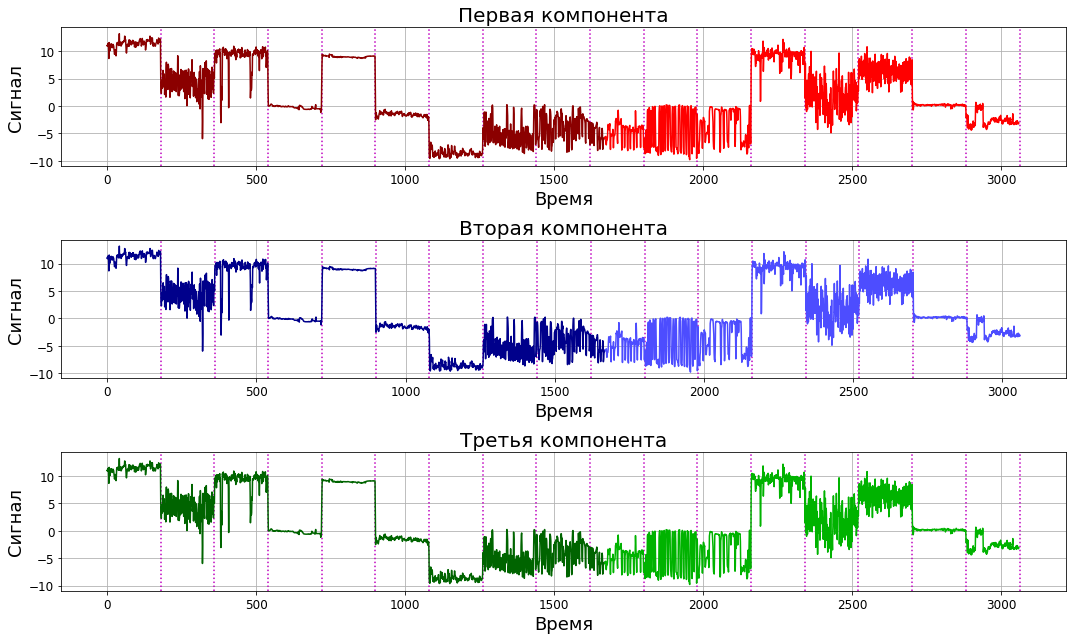

In [31]:
plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(val_end), data[:val_end, 0], c='darkred')
plt.plot(np.arange(test_start, test_end), data[test_start:test_end, 0], c='r')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='Первая компонента', fontsize=20)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Сигнал', fontsize=18)
plt.grid()

plt.subplot(3, 1, 2)

for i in range(len(change_points) - 1):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(val_end), data[:val_end, 0], c='darkblue')
plt.plot(np.arange(test_start, test_end), data[test_start:test_end, 0], c='#4d4dff')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='Вторая компонента', fontsize=20)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Сигнал', fontsize=18)
plt.grid()

plt.subplot(3, 1, 3)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(val_end), data[:val_end, 0], c='darkgreen')
plt.plot(np.arange(test_start, test_end), data[test_start:test_end, 0], c='#00b300')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='Третья компонента', fontsize=20)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Сигнал', fontsize=18)
plt.grid()

plt.tight_layout()
plt.savefig('images/WISDM.png')

### Контрастный метод

#### С линейным классом

In [32]:
p = 1

#--------------------------------------------------------------
# Шаг 1: настройка критического значения на стационарной части
#--------------------------------------------------------------
    
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_linear(ds, p, design='multivariate', delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Критическое значение
z_lin = 0.6 * np.max(S_stationary)
print('Критическое значение:', z_lin)


#--------------------------------------------------------------
# Шаг 2: пропускаем валидационную часть, так как нет
# параметров, которые нужно настраивать
#--------------------------------------------------------------

# Моменты разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]


#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_lin = np.empty(0)

change_points_lin = []

delays_lin = np.empty(0)
current_change_point_ind = 0
false_alarms_lin = 0

st_lin = 0
new_st_lin = 0
    
while new_st_lin >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_lin, new_st_lin = compute_test_stat_linear(data_test[st_lin + 1:], p,\
                                                     design='multivariate', threshold=z_lin, delta_max=50)

    S_lin = np.append(S_lin, new_S_lin)

    if new_st_lin >= 0:
        st_lin += new_st_lin
        change_points_lin += [int(st_lin)]
    else:
        change_points_lin += [int(data_test.shape[0] - 1)]

print('Обнаруженные моменты разладки:', change_points_lin)
    
false_alarms_lin, mean_delay_lin, std_delay_lin, not_detected_lin\
= compute_delays(change_points_test, change_points_lin)

print('Линейный класс. Число ложных срабатываний:', false_alarms_lin,\
      '; средняя задержка обнаружения:', np.round(mean_delay_lin, 4), '±', np.round(std_delay_lin, 4),\
      '; необнаруженных разладок:', not_detected_lin)

Критическое значение: 28.425647953623027
Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные моменты разладки: [148, 375, 506, 703, 878, 1055, 1235, 1389]
Линейный класс. Число ложных срабатываний: 0 ; средняя задержка обнаружения: 28.7143 ± 15.3503 ; необнаруженных разладок: 0


### KLIEP

In [33]:
# Список гиперпараметров
sigma_list = [10, 20, 25, 40, 50]

# Разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Моменты разладок на валидационной части:', change_points_val)
    
# Настройка гиперпараметра 
for sigma in sigma_list:
    
    #--------------------------------------------------------------
    # Шаг 1: настройка критического значения на стационарной части
    #--------------------------------------------------------------    

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_divergence_test_stat(ds, window_size=50, sigma=sigma, method='kliep')
        S_stationary = np.append(S_stationary, S)
        
    # Критическое значение
    z = np.max(S_stationary)
    print(z)
    
    #--------------------------------------------------------------
    # Шаг 2: обнаружение разладок на валидационной части
    #--------------------------------------------------------------

    # Инициализация
    S_kliep = np.empty(0)

    change_points_kliep = []

    delays_kliep = np.empty(0)
    current_change_point_ind = 0
    false_alarms_kliep = 0

    st_kliep = 0
    new_st_kliep = 0
    
    while new_st_kliep >= 0:

        # Запустить алгоритм до момента обнаружения разладки
        new_S_kliep, new_st_kliep = compute_divergence_test_stat(data_val[st_kliep + 1:],\
                                                                 window_size=50, sigma=sigma, threshold=z,\
                                                                 method='kliep')

        S_kliep = np.append(S_kliep, new_S_kliep)

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep
            change_points_kliep += [int(st_kliep)]
        else:
            change_points_kliep += [int(data_val.shape[0] - 1)]

    false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
    = compute_delays(change_points_val, change_points_kliep)

    print('KLIEP, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_kliep,\
          '; средняя задержка обнаружения:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
          '; необнаруженных разладок:', not_detected_kliep)

Моменты разладок на валидационной части: [ 180  360  540  720  900 1080 1260 1440 1620]
0.06283755984517317
KLIEP, параметр = 10 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 10.4444 ± 7.7332 ; необнаруженных разладок: 0
0.014942280274345538
KLIEP, параметр = 20 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 13.8889 ± 11.8925 ; необнаруженных разладок: 0
0.007297372103831361
KLIEP, параметр = 25 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 9.3333 ± 8.705 ; необнаруженных разладок: 0
0.0030688489661537715
KLIEP, параметр = 40 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 13.0 ± 11.5085 ; необнаруженных разладок: 0
0.001946729230324578
KLIEP, параметр = 50 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 13.1111 ± 11.445 ; необнаруженных разладок: 0


In [35]:
#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

z_kliep = 0.06283755984517317
sigma = 10
    
# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_kliep = np.empty(0)

change_points_kliep = []

delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0

st_kliep = 0
new_st_kliep = 0
    
while new_st_kliep >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_kliep, new_st_kliep = compute_divergence_test_stat(data_test[st_kliep + 1:],\
                                                             window_size=50, sigma=sigma, threshold=z_kliep,
                                                             method='kliep')

    S_kliep = np.append(S_kliep, new_S_kliep)

    if new_st_kliep >= 0:
        st_kliep += new_st_kliep
        change_points_kliep += [int(st_kliep)]
    else:
        change_points_kliep += [int(data_test.shape[0] - 1)]

print('Обнаруженные разладки:', change_points_kliep)
    
false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
= compute_delays(change_points_test, change_points_kliep)

print('KLIEP, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_kliep,\
      '; средняя задержка обнаружения:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
      '; необнаруженных разладок:', not_detected_kliep)

Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные разладки: [125, 228, 329, 430, 531, 683, 856, 1040, 1242, 1343, 1389]
KLIEP, параметр = 10 . Число ложных срабатываний: 3 ; средняя задержка обнаружения: 30.0 ± 29.6792 ; необнаруженных разладок: 0


### uLSIF

In [36]:
# Список гиперпараметров
sigma_list = [50, 100, 200, 250, 400, 500]

# Разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Моменты разладок на валидационной части:', change_points_val)
    
# Настройка гиперпараметра 
for sigma in sigma_list:
    
    #--------------------------------------------------------------
    # Шаг 1: настройка критического значения на стационарной части
    #--------------------------------------------------------------    

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_divergence_test_stat(ds, window_size=50, sigma=sigma, method='ulsif')
        S_stationary = np.append(S_stationary, S)
        
    # Критическое значение
    z = np.max(S_stationary)
    print(z)
    
    #--------------------------------------------------------------
    # Шаг 2: обнаружение разладок на валидационной части
    #--------------------------------------------------------------

    # Инициализация
    S_ulsif = np.empty(0)

    change_points_ulsif = []

    delays_ulsif = np.empty(0)
    current_change_point_ind = 0
    false_alarms_ulsif = 0

    st_ulsif = 0
    new_st_ulsif = 0
    
    while new_st_ulsif >= 0:

        # Запустить алгоритм до момента обнаружения разладки
        new_S_ulsif, new_st_ulsif = compute_divergence_test_stat(data_val[st_ulsif + 1:],\
                                                                 window_size=50, sigma=sigma, threshold=z,\
                                                                 method='ulsif')

        S_ulsif = np.append(S_ulsif, new_S_ulsif)

        if new_st_ulsif >= 0:
            st_ulsif += new_st_ulsif
            change_points_ulsif += [int(st_ulsif)]
        else:
            change_points_ulsif += [int(data_val.shape[0] - 1)]

    false_alarms_ulsif, mean_delay_ulsif, std_delay_ulsif, not_detected_ulsif\
    = compute_delays(change_points_val, change_points_ulsif)

    print('uLSIF, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_ulsif,\
          '; средняя задержка обнаружения:', np.round(mean_delay_ulsif, 4), '±', np.round(std_delay_ulsif, 4),\
          '; необнаруженных разладок:', not_detected_ulsif)

Моменты разладок на валидационной части: [ 180  360  540  720  900 1080 1260 1440 1620]
415.23056385653615
uLSIF, параметр = 50 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 41.2222 ± 54.2828 ; необнаруженных разладок: 1
65.06852824244045
uLSIF, параметр = 100 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 45.0 ± 52.5209 ; необнаруженных разладок: 1
8.712945540780344
uLSIF, параметр = 200 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 20.4444 ± 18.252 ; необнаруженных разладок: 0
8.71301000127102
uLSIF, параметр = 250 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 20.6667 ± 18.3 ; необнаруженных разладок: 0
8.71293663980254
uLSIF, параметр = 400 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 20.7778 ± 18.3834 ; необнаруженных разладок: 0
8.712820718023305
uLSIF, параметр = 500 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 20.8889 ± 18.2662 ; необнаруженных разладок: 0


In [37]:
#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

z_ulsif = 8.712945540780344
sigma = 200
    
# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_ulsif = np.empty(0)

change_points_ulsif = []

delays_ulsif = np.empty(0)
current_change_point_ind = 0
false_alarms_ulsif = 0

st_ulsif = 0
new_st_ulsif = 0
    
while new_st_ulsif >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_ulsif, new_st_ulsif = compute_divergence_test_stat(data_test[st_ulsif + 1:],\
                                                             window_size=50, sigma=sigma, threshold=z_ulsif,
                                                             method='ulsif')

    S_ulsif = np.append(S_ulsif, new_S_ulsif)

    if new_st_ulsif >= 0:
        st_ulsif += new_st_ulsif
        change_points_ulsif += [int(st_ulsif)]
    else:
        change_points_ulsif += [int(data_test.shape[0] - 1)]

print('Обнаруженные разладки:', change_points_ulsif)
    
false_alarms_ulsif, mean_delay_ulsif, std_delay_ulsif, not_detected_ulsif\
= compute_delays(change_points_test, change_points_ulsif)

print('uLSIF, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_ulsif,\
      '; средняя задержка обнаружения:', np.round(mean_delay_ulsif, 4), '±', np.round(std_delay_ulsif, 4),\
      '; необнаруженных разладок:', not_detected_ulsif)

Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные разладки: [140, 381, 495, 718, 900, 1067, 1224, 1333, 1389]
uLSIF, параметр = 200 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 32.2857 ± 22.9267 ; необнаруженных разладок: 0


### RuLSIF

In [38]:
# Список гиперпараметров
sigma_list = [0.2, 0.5, 1, 2, 5, 10, 20, 25, 40, 50, 100, 200]

# Разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Моменты разладок на валидационной части:', change_points_val)
    
# Настройка гиперпараметра 
for sigma in sigma_list:
    
    #--------------------------------------------------------------
    # Шаг 1: настройка критического значения на стационарной части
    #--------------------------------------------------------------    

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_divergence_test_stat(ds, window_size=50, sigma=sigma, method='rulsif')
        S_stationary = np.append(S_stationary, S)
        
    # Критическое значение
    z = np.max(S_stationary)
    print(z)
    
    #--------------------------------------------------------------
    # Шаг 2: обнаружение разладок на валидационной части
    #--------------------------------------------------------------

    # Инициализация
    S_rulsif = np.empty(0)

    change_points_rulsif = []

    delays_rulsif = np.empty(0)
    current_change_point_ind = 0
    false_alarms_rulsif = 0

    st_rulsif = 0
    new_st_rulsif = 0
    
    while new_st_rulsif >= 0:

        # Запустить алгоритм до момента обнаружения разладки
        new_S_rulsif, new_st_rulsif = compute_divergence_test_stat(data_val[st_rulsif + 1:],\
                                                                 window_size=50, sigma=sigma, threshold=z,\
                                                                 method='rulsif')

        S_rulsif = np.append(S_rulsif, new_S_rulsif)

        if new_st_rulsif >= 0:
            st_rulsif += new_st_rulsif
            change_points_rulsif += [int(st_rulsif)]
        else:
            change_points_rulsif += [int(data_val.shape[0] - 1)]

    false_alarms_rulsif, mean_delay_rulsif, std_delay_rulsif, not_detected_rulsif\
    = compute_delays(change_points_val, change_points_rulsif)

    print('RuLSIF, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_rulsif,\
          '; средняя задержка обнаружения:', np.round(mean_delay_rulsif, 4), '±', np.round(std_delay_rulsif, 4),\
          '; необнаруженных разладок:', not_detected_rulsif)

Моменты разладок на валидационной части: [ 180  360  540  720  900 1080 1260 1440 1620]
0.499727719840668
RuLSIF, параметр = 0.2 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 57.7778 ± 44.5391 ; необнаруженных разладок: 1
0.49193113022614743
RuLSIF, параметр = 0.5 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 59.2222 ± 43.873 ; необнаруженных разладок: 1
0.4850769431303787
RuLSIF, параметр = 1 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 59.0 ± 43.9242 ; необнаруженных разладок: 1
0.4514697252058011
RuLSIF, параметр = 2 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 55.1111 ± 45.3467 ; необнаруженных разладок: 1
0.43440901224721334
RuLSIF, параметр = 5 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 55.5556 ± 45.1322 ; необнаруженных разладок: 1
0.39892279018255117
RuLSIF, параметр = 10 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 54.0 ± 45.6314 ; необнаруженных разладок: 1
0.3474710664

In [39]:
#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

z_rulsif = 0.3474710664580626
sigma = 20
    
# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_rulsif = np.empty(0)

change_points_rulsif = []

delays_rulsif = np.empty(0)
current_change_point_ind = 0
false_alarms_rulsif = 0

st_rulsif = 0
new_st_rulsif = 0
    
while new_st_rulsif >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_rulsif, new_st_rulsif = compute_divergence_test_stat(data_test[st_rulsif + 1:],\
                                                             window_size=50, sigma=sigma, threshold=z_rulsif,
                                                             method='rulsif')

    S_rulsif = np.append(S_rulsif, new_S_rulsif)

    if new_st_rulsif >= 0:
        st_rulsif += new_st_rulsif
        change_points_rulsif += [int(st_rulsif)]
    else:
        change_points_rulsif += [int(data_test.shape[0] - 1)]

print('Обнаруженные разладки:', change_points_rulsif)
    
false_alarms_rulsif, mean_delay_rulsif, std_delay_rulsif, not_detected_rulsif\
= compute_delays(change_points_test, change_points_rulsif)

print('RuLSIF, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_rulsif,\
      '; средняя задержка обнаружения:', np.round(mean_delay_rulsif, 4), '±', np.round(std_delay_rulsif, 4),\
      '; необнаруженных разладок:', not_detected_rulsif)

Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные разладки: [144, 359, 460, 713, 890, 1070, 1251, 1389]
RuLSIF, параметр = 20 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 57.0 ± 51.2417 ; необнаруженных разладок: 1


### M-статистика

In [40]:
# Список гиперпараметров
sigma_list = [10, 20, 25, 40, 50]

# Разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Моменты разладок на валидационной части:', change_points_val)
    
# Настройка гиперпараметра 
for sigma in sigma_list:
    
    #--------------------------------------------------------------
    # Шаг 1: настройка критического значения на стационарной части
    #--------------------------------------------------------------    

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Критическое значение
    z = np.max(S_stationary)
    print(z)
    
    #--------------------------------------------------------------
    # Шаг 2: обнаружение разладок на валидационной части
    #--------------------------------------------------------------

    # Инициализация
    S_mmd = np.empty(0)

    change_points_mmd = []

    delays_mmd = np.empty(0)
    current_change_point_ind = 0
    false_alarms_mmd = 0

    st_mmd = 0
    new_st_mmd = 0
    
    while new_st_mmd >= 0:

        # Запустить алгоритм до момента обнаружения разладки
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            change_points_mmd += [int(st_mmd)]
        else:
            change_points_mmd += [int(data_val.shape[0] - 1)]

    false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
    = compute_delays(change_points_val, change_points_mmd)

    print('M-статистика, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_mmd,\
          '; средняя задержка обнаружения:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
          '; необнаруженных разладок:', not_detected_mmd)

Моменты разладок на валидационной части: [ 180  360  540  720  900 1080 1260 1440 1620]
5.217594927197018
M-статистика, параметр = 10 . Число ложных срабатываний: 2 ; средняя задержка обнаружения: 13.7778 ± 15.0095 ; необнаруженных разладок: 0
1.7284497814725275
M-статистика, параметр = 20 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 9.1111 ± 8.7996 ; необнаруженных разладок: 0
1.1237385679629701
M-статистика, параметр = 25 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 9.1111 ± 8.7996 ; необнаруженных разладок: 0
0.44657933683968337
M-статистика, параметр = 40 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 9.1111 ± 8.7996 ; необнаруженных разладок: 0
0.2869555417166241
M-статистика, параметр = 50 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 9.1111 ± 8.7996 ; необнаруженных разладок: 0


In [41]:
#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

z_mmd = 1.7284497814725275
sigma = 20
    
# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_mmd = np.empty(0)

change_points_mmd = []

delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

st_mmd = 0
new_st_mmd = 0
    
while new_st_mmd >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_test[st_mmd + 1:],\
                                                      window_size=50, sigma=sigma, threshold=z_mmd)

    S_mmd = np.append(S_mmd, new_S_mmd)

    if new_st_mmd >= 0:
        st_mmd += new_st_mmd
        change_points_mmd += [int(st_mmd)]
    else:
        change_points_mmd += [int(data_test.shape[0] - 1)]

print('Обнаруженные разладки:', change_points_mmd)
    
false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
= compute_delays(change_points_test, change_points_mmd)

print('M-статистика, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_mmd,\
      '; средняя задержка обнаружения:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
      '; необнаруженных разладок:', not_detected_mmd)

Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные разладки: [121, 226, 327, 428, 529, 681, 782, 883, 1039, 1229, 1330, 1389]
M-статистика, параметр = 20 . Число ложных срабатываний: 4 ; средняя задержка обнаружения: 30.7143 ± 28.2424 ; необнаруженных разладок: 0


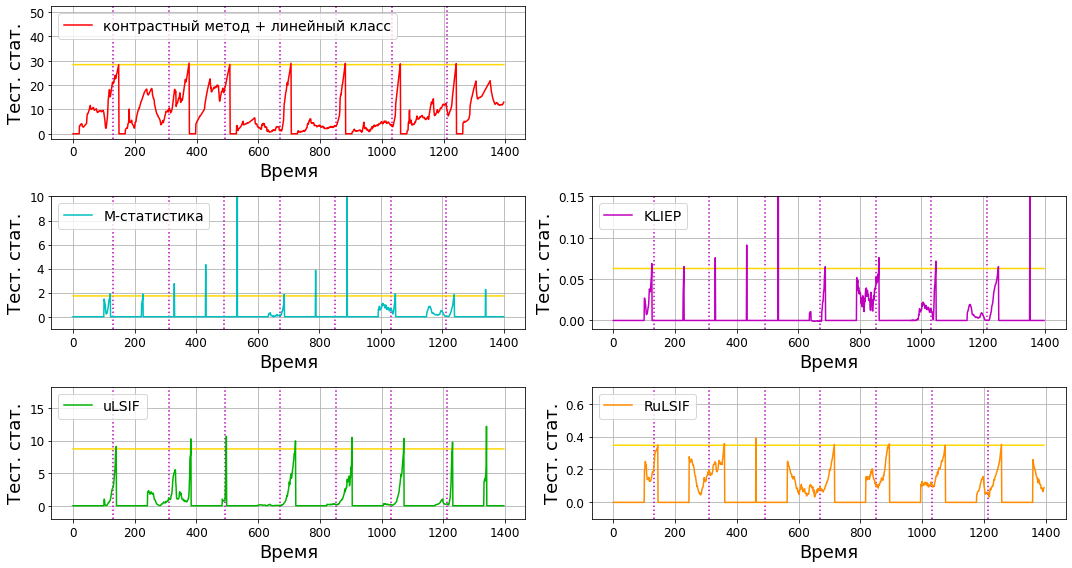

In [46]:
# Построение графиков зависимости тестовых статистик различных
# методов обнаружения разладки от времени

plt.figure(figsize=(15, 8))


plt.subplot(3, 2, 1)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')

plt.plot(np.arange(len(S_lin)), [z_lin] * len(S_lin), c='gold')
plt.plot(np.arange(len(S_lin)), S_lin, c='r', label='контрастный метод + линейный класс')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.grid()
plt.ylim((-2, 1.8 * np.max(S_lin)))

plt.subplot(3, 2, 3)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_mmd)), [z_mmd] * len(S_mmd), c='gold')
plt.plot(np.arange(len(S_mmd)), S_mmd, c='c', label='M-статистика')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.ylim((-1, 10))
plt.grid()

plt.subplot(3, 2, 4)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_kliep)), [z_kliep] * len(S_kliep), c='gold')
plt.plot(np.arange(len(S_kliep)), S_kliep, c='m', label='KLIEP')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.ylim((-0.01, 0.15))
plt.grid()

plt.subplot(3, 2, 5)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_ulsif)), [z_ulsif] * len(S_ulsif), c='gold')
plt.plot(np.arange(len(S_ulsif)), S_ulsif, c='#00b300', label='uLSIF')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.ylim((-2, 1.5 * np.max(S_ulsif)))
plt.grid()

plt.subplot(3, 2, 6)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_rulsif)), [z_rulsif] * len(S_rulsif), c='gold')
plt.plot(np.arange(len(S_rulsif)), S_rulsif, c='darkorange', label='RuLSIF')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.ylim((-0.1, 1.8 * np.max(S_rulsif)))
plt.grid()

plt.tight_layout()

plt.savefig('images/WISDM_results.png')